# Applied Machine Learning 
# Project - Predicting California Wine Price
# Student name: Jiang Jiang

## 1. Import the data

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import math
from matplotlib.pyplot import figure

# The command below means that the output of multiple commands in a cell will be output at once
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# The command below tells jupyter to display up to 80 columns, this keeps everything visible
pd.set_option('display.max_columns', 80)
pd.set_option('expand_frame_repr', True)

# Show figures in notebook
%matplotlib inline

In [65]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

If you don't have tensorflow installed, you can upload this jupyter notebook onto your google drive and open it with Colabratory.

In [46]:
# import data
path = '../data/'
file1 = 'winemag_data.csv'
df_org = pd.read_csv(path+file1)

## 2. Data cleaning and mutation

In [47]:
# filter: only keep the California wine
df_org = df_org[df_org.province=='California']
# quick review of the first five rows
df_org.head()
df_org.info()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
10,10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
12,12,US,"Slightly reduced, this wine offers a chalky, t...",NaN,87,34.0,California,Alexander Valley,Sonoma,Virginie Boone,@vboone,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini
14,14,US,Building on 150 years and six generations of w...,NaN,87,12.0,California,Central Coast,Central Coast,Matt Kettmann,@mattkettmann,Mirassou 2012 Chardonnay (Central Coast),Chardonnay,Mirassou
23,23,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,Bianchi 2011 Signature Selection Merlot (Paso ...,Merlot,Bianchi
25,25,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,Castello di Amorosa 2011 King Ridge Vineyard P...,Pinot Noir,Castello di Amorosa


<class 'pandas.core.frame.DataFrame'>
Int64Index: 36247 entries, 10 to 129952
Data columns (total 14 columns):
Unnamed: 0               36247 non-null int64
country                  36247 non-null object
description              36247 non-null object
designation              24359 non-null object
points                   36247 non-null int64
price                    36104 non-null float64
province                 36247 non-null object
region_1                 36245 non-null object
region_2                 34119 non-null object
taster_name              20174 non-null object
taster_twitter_handle    20174 non-null object
title                    36247 non-null object
variety                  36247 non-null object
winery                   36247 non-null object
dtypes: float64(1), int64(2), object(11)
memory usage: 4.1+ MB


We can witness that there are some missing values in designation.

In [48]:
# drop the columns we don't need and rows with missing data
# reset the index

df_org = df_org.drop(['Unnamed: 0','country','designation','province','taster_name',
              'taster_twitter_handle'], axis=1)
df_org = df_org.dropna()
df_org = df_org.reset_index(drop=True)

#### Get vintage from the 'title' column

In [49]:
# create vintage column from the 'title column' by extracting the numbers in the title
import re
def vintage(df): 
    temp = re.findall('\d+', df.title)
    if temp:
        df['vintage']= int(temp[0])
    else:
        df['vintage']= 0
    return df

df_org = df_org.apply(vintage, axis=1)

In [50]:
# remove the rows with unvalid vintage information
df_org = df_org[(df_org.vintage>1900) & (df_org.vintage<2018)]

#### Recode the variety column

In [32]:
# review what varieties we have
df_org.variety.value_counts().head(10)

Pinot Noir                  6292
Cabernet Sauvignon          5525
Chardonnay                  4946
Zinfandel                   2485
Syrah                       1805
Red Blend                   1677
Sauvignon Blanc             1605
Merlot                      1350
Bordeaux-style Red Blend     862
Petite Sirah                 626
Name: variety, dtype: int64

Only keep “Cabernet Sauvignon”, “Merlot”, “Pinot Noir”, “Syrah”, "Red Blend",
and “Zinfandel” for red wines; “Chardonnay” and “Sauvignon Blanc” for white
wines; and “other” for all other minor grape varieties

In [51]:
# create a function to change the uncommon varieties into 'others'
def variety(df): 
    
    if df.variety not in ['Cabernet Sauvignon', 'Merlot', 'Pinot Noir', 'Syrah', 
                          'Zinfandel','Chardonnay', 'Sauvignon Blanc','Red Blend']:
        df.variety= 'other'
    else:
        df.variety = df.variety
    return df

df_org = df_org.apply(variety, axis=1)

#### Recode the region_2 to reflect the social classification
Specifically, we are going to assign 'other' to all the observations without region_2 information.

In [34]:
df_org.region_2.value_counts()

Central Coast       10975
Sonoma               9009
Napa                 6804
California Other     2661
Sierra Foothills     1461
Napa-Sonoma          1169
Central Valley       1058
North Coast           583
South Coast           262
Name: region_2, dtype: int64

In [52]:
# create a function to fill in the missing region_2 with 'other'
def region2(df): 
    
    if df.region_2:
        df.region_2 = df.region_2
    else:
        df.region_2 = 'other'
    return df

df_org = df_org.apply(region2, axis=1)

#### Recode the price column
Because the price distribution is skewed (see section 3: Explore the data), we can tranform the data using log function.

In [53]:
# transfer price using log function
import math
df_org=df_org.assign(priceLog = lambda x: np.log(x.price))

In [54]:
df_org.priceLog.describe()

count    33089.000000
mean         3.500614
std          0.593992
min          1.386294
25%          3.091042
50%          3.526361
75%          3.891820
max          7.607381
Name: priceLog, dtype: float64

In [55]:
df_org.head()

,description,points,price,region_1,region_2,title,variety,winery,vintage,priceLog
0,"Soft, supple plum envelopes an oaky structure ...",87,19.0,Napa Valley,Napa,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature,2011,2.944439
1,"Slightly reduced, this wine offers a chalky, t...",87,34.0,Alexander Valley,Sonoma,Louis M. Martini 2012 Cabernet Sauvignon (Alex...,Cabernet Sauvignon,Louis M. Martini,2012,3.526361
2,Building on 150 years and six generations of w...,87,12.0,Central Coast,Central Coast,Mirassou 2012 Chardonnay (Central Coast),Chardonnay,Mirassou,2012,2.484907
3,This wine from the Geneseo district offers aro...,87,22.0,Paso Robles,Central Coast,Bianchi 2011 Signature Selection Merlot (Paso ...,Merlot,Bianchi,2011,3.091042
4,Oak and earth intermingle around robust aromas...,87,69.0,Sonoma Coast,Sonoma,Castello di Amorosa 2011 King Ridge Vineyard P...,Pinot Noir,Castello di Amorosa,2011,4.234107


#### Get the dummy variables 

In [56]:
# getting the dummy variables
region = pd.get_dummies(df_org['region_1'])
region2 = pd.get_dummies(df_org['region_2'])
winery= pd.get_dummies(df_org.winery)
variety= pd.get_dummies(df_org.variety)
vintage= pd.get_dummies(df_org.vintage)

df=df_org.join(region,rsuffix='_region')
df=df.join(region,rsuffix='_region2')
df=df.join(winery,rsuffix='_winery')
df=df.join(variety)
df=df.join(vintage)

df.describe()

,points,price,vintage,priceLog,Adelaida District,Alexander Valley,Alta Mesa,Amador County,Amador-Napa,Antelope Valley of the California High Desert,Arroyo Grande Valley,Arroyo Seco,Atlas Peak,Ballard Canyon,Ben Lomond Mountain,Bennett Valley,Calaveras County,California,Calistoga,Capay Valley,Carmel Valley,Carneros,Carneros-Napa Valley,Central Coast,Chalk Hill,Chalone,Chiles Valley,Cienega Valley,Clarksburg,Clements Hills,Contra Costa County,Coombsville,Cucamonga Valley,Diamond Mountain District,Dry Creek Valley,Dunnigan Hills,Edna Valley,El Dorado,El Dorado County,El Pomar District,...,Cabernet Sauvignon,Chardonnay,Merlot,Pinot Noir,Red Blend,Sauvignon Blanc,Syrah,Zinfandel,other,1985,1986,1987,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
count,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,...,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.00000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000,33089.000000
mean,88.661640,39.865454,2010.502463,3.500614,0.003324,0.023422,0.000272,0.011635,0.000060,0.000091,0.004835,0.006316,0.002025,0.002388,0.000635,0.002236,0.002659,0.068905,0.004443,0.000091,0.002871,0.029526,0.000695,0.021095,0.002659,0.002085,0.000363,0.000635,0.003022,0.000484,0.002206,0.001632,0.000272,0.004624,0.028166,0.001179,0.012209,0.009248,0.000604,0.000181,...,0.164858,0.147511,0.040074,0.188461,0.046450,0.047901,0.054248,0.073801,0.236695,0.000030,0.000030,0.000030,0.000030,0.000030,0.000091,0.000121,0.000030,0.000272,0.000212,0.000393,0.005833,0.005712,0.006498,0.00677,0.004715,0.000907,0.002025,0.012633,0.032246,0.049745,0.058116,0.059960,0.081870,0.099912,0.086947,0.140077,0.151440,0.122458,0.053613,0.017256
std,3.266805,30.992979,3.569834,0.593992,0.057562,0.151241,0.016490,0.107239,0.007774,0.009522,0.069370,0.079225,0.044953,0.048804,0.025185,0.047238,0.051502,0.253296,0.066505,0.009522,0.053506,0.169279,0.026356,0.143702,0.051502,0.045618,0.019040,0.025185,0.054892,0.021985,0.046919,0.040365,0.016490,0.067843,0.165451,0.034312,0.109822,0.095721,0.024578,0.013465,...,0.371058,0.354620,0.196135,0.391086,0.210462,0.213560,0.226509,0.261451,0.425060,0.005497,0.005497,0.005497,0.005497,0.005497,0.009522,0.010994,0.005497,0.016490,0.014543,0.019818,0.076151,0.075362,0.080347,0.08200,0.068502,0.030097,0.044953,0.111684,0.176656,0.217420,0.233966,0.237415,0.274171,0.299888,0.281762,0.347072,0.358483,0.327819,0.225256,0.130228
min,80.000000,4.000000,1985.000000,1.386294,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000

In [57]:
# check the shape of the final dataframe (33982, 4214)
df.shape

(33089, 4007)

There are 4214 columns. I might reduce the dimensions in the second half of the project. But we'll use this dataframe for now.

## 3. Explore the data

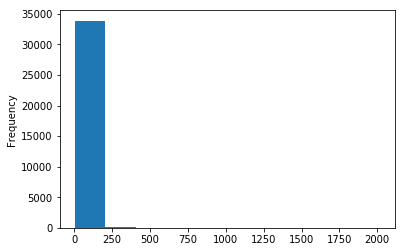

In [16]:
df.price.plot('hist')

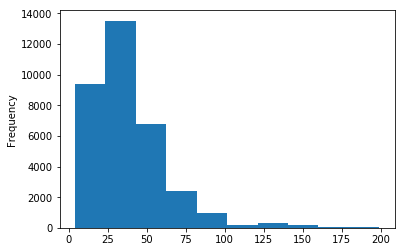

In [17]:
df[df.price < 200].price.plot(kind='hist')

The price column is skewed. What about log(price)?

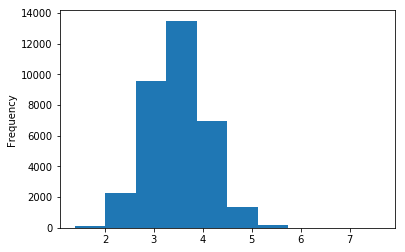

In [18]:
df.priceLog.plot('hist')

Log of price is more normally distributed. That's why we are going to use log(price) as the target variable.

(0, 500)

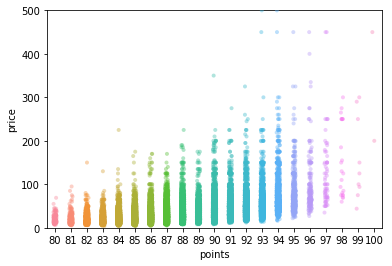

In [19]:
# visualize the relationship between points nad price
p=sns.stripplot(x='points',y='price', data=df, size=4, jitter=True, alpha = 0.4)
p.set_ylim([0,500])

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

(0, 250)

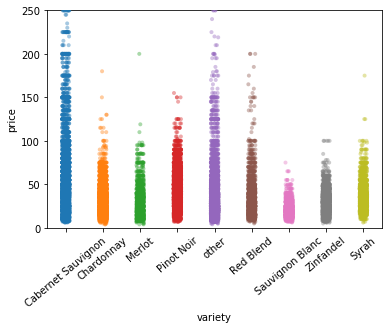

In [20]:
# visualize the relationship between variety nad price
sns.stripplot(x='variety',y='price', data=df, size=4, jitter=True, alpha = 0.4)
plt.xticks(x='variety', rotation='40')
plt.ylim(0,250)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]), <a list of 9 Text xticklabel objects>)

(0, 250)

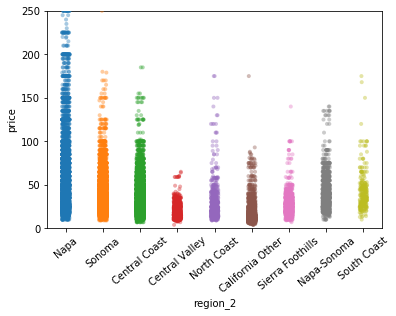

In [21]:
# visualize the relationship between region2 nad price
sns.stripplot(x='region_2',y='price', data=df_org, size=4, jitter=True, alpha = 0.4)
plt.xticks(x='variety', rotation='40')
plt.ylim(0,250)

Looks like the relationship between any single dependent variable with 'price' is not clear.

## 4. Modeling phase

In [58]:
# Get all the columns
# Select explanatory features and outcome features; Store them in X and y
df.columns
X=df.drop(['price','winery','vintage','region_1','region_2',
           'variety','title','description'], axis=1)
y=df.priceLog

Index(['description',      'points',       'price',    'region_1',
          'region_2',       'title',     'variety',      'winery',
           'vintage',    'priceLog',
       ...
                2007,          2008,          2009,          2010,
                2011,          2012,          2013,          2014,
                2015,          2016],
      dtype='object', length=4007)

In [59]:
# Get training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [60]:
# Get the number of observations
X_train.shape
ncol=X_train.shape[1]

(23162, 3999)

 Saving the features to a csv file (not used)
np.savetxt("explanatory.csv", X, delimiter=",")

 Saving the target column to a csv file (not used)
np.savetxt("target.csv", y, delimiter=",")

### 4.1 Neural Network

In [25]:
from keras.layers import Dense
from keras.models import Sequential

Using TensorFlow backend.


In [29]:
# Building the structure of the neural network
# two hidden layers, with 100 nodes each layer
# loss function is MSE and optimizer is adam
# Adam - source: https://github.com/keras-team/keras/blob/master/keras/optimizers.py#L436
act='selu'
num=100
nn1 = Sequential()
nn1.add(Dense(num,activation=act, input_shape = (ncol,)))
nn1.add(Dense(num, activation=act))
nn1.add(Dense(num, activation=act))
nn1.add(Dense(1, activation=act)) 
nn1.compile(loss='mse', optimizer='adam')
nn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 100)               420700    
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 101       
Total params: 441,001
Trainable params: 441,001
Non-trainable params: 0
_________________________________________________________________


In [30]:
# fit the model and get test results: epochs = 20, batch size = 50.
# it might take 5 minutes to run the codes
history_nn1 = nn1.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=50,
                    validation_data=(X_test, y_test))

Train on 23787 samples, validate on 10195 samples
Epoch 1/20
23787/23787 [==============================] - 16s 680us/step - loss: 0.1432 - val_loss: 0.0137
Epoch 2/20
23787/23787 [==============================] - 14s 602us/step - loss: 0.0147 - val_loss: 0.0111
Epoch 3/20
23787/23787 [==============================] - 15s 644us/step - loss: 0.0093 - val_loss: 0.0102
Epoch 4/20
23787/23787 [==============================] - 15s 641us/step - loss: 0.0092 - val_loss: 0.0058
Epoch 5/20
23787/23787 [==============================] - 16s 666us/step - loss: 0.0073 - val_loss: 0.0048
Epoch 6/20
23787/23787 [==============================] - 16s 677us/step - loss: 0.0076 - val_loss: 0.0086
Epoch 7/20
23787/23787 [==============================] - 16s 665us/step - loss: 0.0063 - val_loss: 0.0024
Epoch 8/20
23787/23787 [==============================] - 16s 652us/step - loss: 0.0056 - val_loss: 0.0022
Epoch 9/20
23787/23787 [==============================] - 16s 667us/step - loss: 0.0047 - val_

### Discuss the results

Text(0.5, 1.0, 'Training and test loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

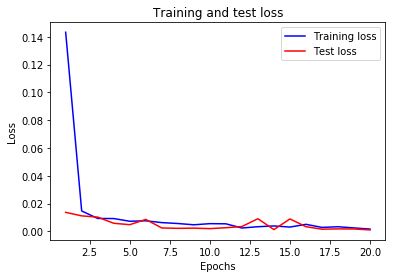

In [31]:
# get the learning curve
loss = history_nn1.history['loss']
val_loss = history_nn1.history['val_loss']
epochs = range(1, len(loss) + 1);
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Training and test loss')

Text(0.5, 0, 'Epochs')

Text(0, 0.5, 'Loss')

(0, 0.02)

(5, 20)

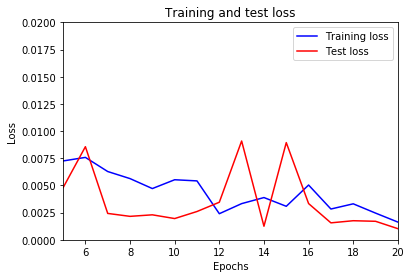

In [32]:
# Have a closer look at epochs after 5
# get the learning curve
loss = history_nn1.history['loss']
val_loss = history_nn1.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss');
plt.plot(epochs, val_loss, 'r', label='Test loss');
plt.title('Training and test loss');
plt.xlabel('Epochs');
plt.ylabel('Loss');
plt.legend()
plt.ylim(0,0.02);
plt.xlim(5,20);
plt.show()

Looks like the losses are not very steady. But the good thing is the training and test losses are very close even after a close scrutiny. We can say this model is not overfitting or underfitting.
<br>
<br>
It's very interesting to see that test loss is actually lower than training loss sometimes. One explanation is that training set has more 'outliers' due to the large volume of data.
<br>
<br>
Let's plot the comparion between the predicted value and true/observed value of price.

<Figure size 800x400 with 0 Axes>

Text(0.5, 0, 'predicted log price')

Text(0, 0.5, 'observed log price')

Text(0.5, 1.0, 'predicted log price vs real log price - test set')

Text(0.5, 0, 'predicted price')

Text(0, 0.5, 'observed price')

Text(0.5, 1.0, 'predicted price vs real price - test set')

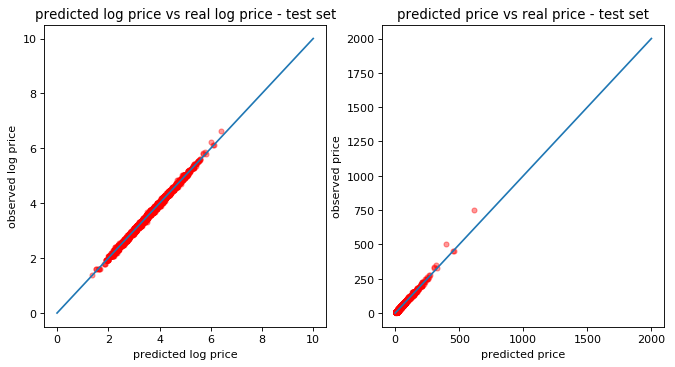

In [33]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')

# Getting the 'Q-Q' plot between predicted log price and real log price 
plt.subplot(1,2,1)
plt.scatter(nn1.predict(X_test),y_test,s=20,alpha=0.4, c='r')
plt.xlabel('predicted log price')
plt.ylabel('observed log price')
plt.title('predicted log price vs real log price - test set')
ident = [0.0, 10.0]
plt.plot(ident,ident)

# Getting the 'Q-Q' plot between predicted price and real price
plt.subplot(1,2,2)
plt.scatter(np.exp(nn1.predict(X_test)),np.exp(y_test),s=20,c='r', alpha=0.4)
ident = [0.0, 2000.0]
plt.plot(ident,ident)
plt.xlabel('predicted price')
plt.ylabel('observed price')
plt.title('predicted price vs real price - test set')
plt.show()

The model did a good job predicting the price log, and therefore, predicting the price. Most of the points fall on the diagnol line.
<br>
<br>
And the errors are evenly distributed along both sides of the diagnol line. We can then check how errors in the test set are distributed by plotting the errors against true price value.

In [34]:
# calculating the error in the test set
price_pred=np.exp(nn1.predict(X_test))
error = price_pred[:,0] - np.exp(y_test)

<Figure size 800x400 with 0 Axes>

Text(0.5, 0, 'observed price')

Text(0, 0.5, 'prediction error')

Text(0.5, 1.0, 'prediction error ~ real price')

Text(0.5, 0, 'observed price')

Text(0, 0.5, 'prediction error')

Text(0.5, 1.0, 'prediction error ($) ~ real price, zoomed in low price range')

(-50, 25)

(0, 200)

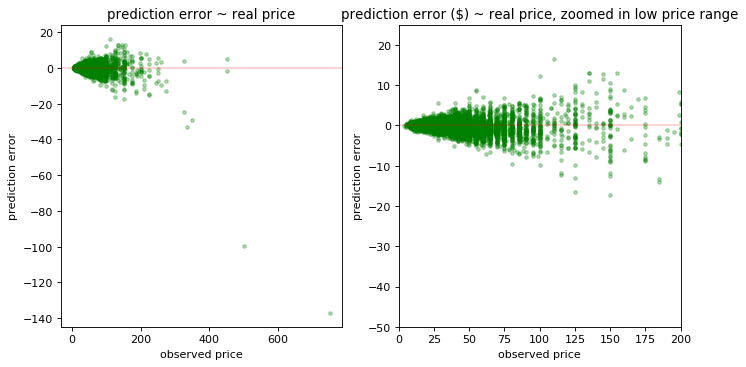

In [35]:
figure(num=None, figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1,2,1)
plt.scatter(np.exp(y_test),error,s=10,c='g', alpha=0.3)
plt.xlabel('observed price')
plt.ylabel('prediction error')
plt.title('prediction error ~ real price')
plt.axhline(y=0, color='r', linestyle='-',linewidth=0.3)

plt.subplot(1,2,2)
plt.scatter(np.exp(y_test),error,s=10,c='g', alpha=0.3)
plt.xlabel('observed price')
plt.ylabel('prediction error')
plt.title('prediction error ~ real price, zoomed in low price range')
plt.axhline(y=0, color='r', linestyle='-',linewidth=0.3)
plt.ylim(-50,25)
plt.xlim(0,200)
plt.show()

It's clear that the model suffers from heteroskedasticity. 
We'll need to bring in more features to solve the issue.

<br>
<br>
Let's quickly calculate the R square of this neural network.

In [36]:
# Getting test set R^2 of the neural network model
mae_nn1=mean_absolute_error(np.exp(y_test),np.exp(model.predict(X_test)))
r2_nn1=r2_score(np.exp(y_test),np.exp(model.predict(X_test)))

0.9957523078179463

0.9933129015266837

More than 99% of the variations in price can be explained by the model.
And on average the prediction error is one dollar.
<br>
This is a good model!

### A surprise: Linear regression

In [19]:
# Getting test set R^2 of the linear regression model as baseline
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, y_train)

In [20]:
r2_reg=reg.score(X_test, y_test);
mae_reg=mean_absolute_error(y_test,reg.predict(X_test))

0.9999999999899544

NameError: name 'mean_absolute_error' is not defined

It looks like that simple linear regression model makes even better predictions. That's a big surprise. <br> This proves that sometimes simpler model can perform better.

# -----------------End of first half of the project-------------------

### 4.2 random forest algorithm

In [68]:
# training the regressor
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=200,max_depth=10,bootstrap=False,
                             random_state=0,min_samples_split=20,min_samples_leaf=10)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=20,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [69]:
# reporting accuracy from the training set
r2_rfr=rfr.score(X_train,y_train)

In [71]:
r2_rfr

0.999590284120252

In [70]:
# reporting accuracy from the test set
r2_rfr=rfr.score(X_test,y_test)
mae_rfr=mean_absolute_error(y_test,rfr.predict(X_test))

In [72]:
re_rfr
mae_rfr

0.9996987265112977

0.0005869389056901361

### 4.3 naive bayes as baseline

In [ ]:
# traning the classifier
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)

In [ ]:
# reporting accuracy from the training set
model.score(X_train,y_train)

In [ ]:
# reporting accuracy from the test set
model.score(X_test,y_test)

### 4.4 XGBoosting algorithm

In [62]:
from xgboost import XGBRegressor
# fit model to training data
xgb_model = XGBRegressor().fit(X_train, y_train)

In [64]:
from sklearn.metrics import r2_score
r2_score(y_train, xgb_model.predict(X_train))
r2_score(y_test, xgb_model.predict(X_test))

0.99999041901923

0.9999640805081401

In [66]:
mean_absolute_error(y_test,xgb_model.predict(X_test))

0.0006992677025319189

### 4.5 Trying to use Functional API with descriptions as aux input

Previously, we mentioned that the neural network we build in 4.1 suffered from heteroskedasticity. Therefore, we could like to add in more features. The only features we didn't use in the past are test features, e.g. description. By using Functional API, we are able to process the text features first and then integrate the results into the main neural network.
<br>
<br>
See https://keras.io/getting-started/functional-api-guide/

In [ ]:
# Getting datasets from the dataframe
num_data=df.drop(['price','winery','vintage','region_1','region_2',
                         'variety','title','description'], axis=1).as_matrix()
text_data = df.description.as_matrix()
labels=df.priceLog.as_matrix()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords

In [ ]:
# preprocessing text data
from keras.preprocessing.text import Tokenizer
# tokenize the most often 150 words
tokenizer = Tokenizer(num_words=150)
tokenizer.fit_on_texts(text_data)
word_index = tokenizer.word_index
# convert descriptions into matrix
text_data=tokenizer.texts_to_matrix(text_data,mode='binary')
print('Found %s unique tokens.' % len(word_index))

In [ ]:
# separating training sets and test sets
num1, num2, txt1, txt2, labels1, labels2 = train_test_split(
    num_data, text_data, labels, test_size=0.30, random_state=42)
# Getting the number of features
ncol=num_data.shape[1]

In [ ]:
# First working on the text part
from keras.layers import Input, Embedding, LSTM, Dense, Concatenate
from keras.models import Model

# Description input: meant to receive sequences of 150 integers
# Naming this layer by passing it a "name" argument.
text_input = Input(shape=(150,), dtype='int32', name='text_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 512-dimensional vectors.
x = Embedding(output_dim=512, input_dim=10000, input_length=150)(text_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out = LSTM(32)(x)

In [ ]:
lstm_out.shape

In [ ]:
# Output of using description to predict price
text_output = Dense(1, activation='selu', name='text_output')(lstm_out)

In [ ]:
# Then adding in the non-text part
num_input = Input(shape=(ncol,), name='num_input')
x = Concatenate(axis=-1)([lstm_out, num_input])

# Stacking a deep densely-connected network on top
x = Dense(100, activation='selu')(x)
x = Dense(100, activation='selu')(x)

# And finally adding the main fitting output
main_output = Dense(1, activation='selu', name='main_output')(x)

In [ ]:
# Putting the model together with two inputs and one outputs
model2 = Model(inputs=[text_input, num_input], outputs=[main_output, text_output])

# The codes below might take 10 minutes to run

In [ ]:
# Compiling and fitting the neural network
# Since we have more inputs, I changed the batch size into 100.
nn2.compile(loss='mse', 
              optimizer='adam',
              loss_weights=[1., 0.00001])
history_nn2=nn2.fit([txt1, num1], [labels1,labels1],
                  epochs=8, batch_size=100, 
                  validation_data=([txt2, num2], [labels2,labels2]))

In [ ]:
# Visualizing the training loss and test loss
loss = history_nn2.history['main_output_loss']
val_loss = history_nn2.history['val_main_output_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
# getting the predicted price from the test set
out_pc=np.exp(nn2.predict([txt2,num2])[0])
out_pc=np.squeeze(out_pc)

In [ ]:
# getting the real price from the test set
real_pc=np.exp(labels2)

In [ ]:
# calculating the error
error2=out_pc - real_pc

In [ ]:
out_pc
real_pc

In [ ]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(10,5), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1,2,1)
plt.scatter(real_pc,error2,s=10,c='g', alpha=0.3)
plt.xlabel('observed price')
plt.ylabel('prediction error')
plt.title('prediction error ~ real price')
plt.axhline(y=0, color='r', linestyle='-',linewidth=0.3)

plt.subplot(1,2,2)
plt.scatter(real_pc,error2,s=10,c='g', alpha=0.3)
plt.xlabel('observed price')
plt.ylabel('prediction error')
plt.title('prediction error ($) ~ real price, zoomed in low price range')
plt.axhline(y=0, color='r', linestyle='-',linewidth=0.3)
plt.xlim(0,200)
plt.show()

The errors distribute more evenly than the simple sequential neural network. The heteroskedasticity is reduced.

In [ ]:
mean_absolute_error(real_pc,out_pc)
r2_score(real_pc,out_pc)

The mean absolute error performs worse by 40 cents. R square decreased by 0.0043.